In [1]:
#importing libraries
import statsmodels.tsa.stattools
import statsmodels.graphics.tsaplots
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
import scipy.stats
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plty

In [2]:
#if this is the first time running the script, please let the next two lines commented to make sure the code works.
#If the code runs, please feel free to uncomment and let the code rerun to ignore any warnings

import warnings
warnings.filterwarnings('ignore')

# Get Time Frame

Indicate below the range of months you are interested in. 

<b> Important </b> <br>
<ul> 
<li> indicate the month indication in a non Python-way <br>
    Code has been created in such a way that input will be interpreted as such. If you are interested in the entire year, do not put df_maker(1,13) (as you would do in a Python way) but df_maker(1,12). The code will understand.
    <p>
<li> code is implemented as range <br>
    If you are interested in single months, you will need to establish two variables with single range.
    Example: <br>
    january = df_maker(1,1) <br>
    august = df_maker(8,8) <br>
    Kindly note that in this case, code will need to be run for each variable
    <p>
<li> comparison needs to be done manually <br>
    if you are interested in comparing two different time frames, you will need to this manually
    
</ul>
    
<br>

<b> Examples </b> <br>
1,12 = entire year (January to December)<br>
1,6 = first wave (January to June) <br>
7, 12 = second wave (July to December) <br>
3,5 = March to May<br>


In [3]:
a = input("Please enter the starting month as a full number. (E.g. for January = 1)")
b = input("Please enter the ending month as a full number. (E.g. for December = 12)")

a = int(a)
b = int(b)

Please enter the starting month as a full number. (E.g. for January = 1)1
Please enter the ending month as a full number. (E.g. for December = 12)12


# Set Up / Establishing Functions

Below, functions and other parts for the code are established. No need to change anything, just let the cells run.

In [4]:
#read in data and data cleaning
df = pd.read_csv("zeitreihe.csv", delimiter = ",")
df = df.set_index("tage")
df = df.rename(columns = {"0": "artikel_zahlen", 
                          "0_kom" : "kom_zahlen", 
                          "entries_fall": "bag_zahlen", 
                          "entries_hosp" : "hosp_zahlen",
                          "entries_tod": "tod_zahlen"})
df = df.fillna(0)
df = df.reset_index()
df["month"] = pd.to_datetime(df["tage"]).dt.month

In [5]:
def df_maker(a,b):
    """
    Creates the df based on the month range of interest
    """
    months_of_interest = [x for x in range(a,b+1)]

    df1 = df[df["month"].isin(months_of_interest)].set_index("tage").drop(["month"], axis = 1)
    return df1

In [6]:
def single_values(df): 
    
    """
    Calculates the metrics for the undifferentiated dataset.
    """
    
    #shapiro
    shapiro_dict = {"name" : ["shapiro-statistic", "shapiro-pvalue"]}
    for column in df:
        x = column
        y = scipy.stats.shapiro(df[column])
        shapiro_dict[x] = [y.statistic, y.pvalue]

    shapiro_df = pd.DataFrame.from_dict(shapiro_dict)
    main_df = shapiro_df
    
    
    #test for stationarity via Augmented Dicky Fuller

    adf_dict = {"name" : ["adf-statistics", "adf-pvalue", "adf-lags", "adf-nobs", "adf-critical-values"]}
    for column in df:
        x = column
        y = statsmodels.tsa.stattools.adfuller(df[column])
        adf_dict[x] = [y[0], y[1], y[2], y[3], y[4]]

    adf_df = pd.DataFrame.from_dict(adf_dict)
    main_df = main_df.append(adf_df)
    
    #test for stationarity via KPSS
    kpss_dict = {"name" : ["kpss-statistics", "kpss-pvalue", "kpss-lags", "kpss-critvalues"]}
    for column in df:
        x = column
        y = statsmodels.tsa.stattools.kpss(df[column])
        kpss_dict[x] = [y[0], y[1], y[2], y[3]]

    kpss_df = pd.DataFrame.from_dict(kpss_dict)
    main_df = main_df.append(kpss_df)
    return main_df

In [7]:
def correlater(df):

    #Spearman correlation

    todo = [[df.bag_zahlen, df.artikel_zahlen], [df.bag_zahlen, df.kom_zahlen], 
            [df.tod_zahlen, df.artikel_zahlen], [df.tod_zahlen, df.kom_zahlen],
            [df.hosp_zahlen, df.artikel_zahlen], [df.hosp_zahlen, df.kom_zahlen],
            [df.artikel_zahlen, df.kom_zahlen]]
    cor_dict = {"name" : ["spearman-statistic", "spearman-pvalue"]}

    for element in todo:
        a = element[0].name
        b = element[1].name
        x = element[0]
        y = element[1]
        z = scipy.stats.spearmanr(x,y)
        cor_dict[(a, b)] = ["{:.6f}".format(float(z.correlation)), "{:.6f}".format(float(z.pvalue))]

    cor_df = pd.DataFrame.from_dict(cor_dict)
    
    
    #just for fun we check pearson nonetheless

    pearson_dict = {"name" : ["pearson-tail1", "pearson-tail2"]}

    for element in todo:
        a = element[0].name
        b = element[1].name
        x = element[0]
        y = element[1]
        z = scipy.stats.pearsonr(x,y)
        pearson_dict[(a, b)] = z

    pearson_df = pd.DataFrame.from_dict(pearson_dict)
    cor_df = cor_df.append(pearson_df)
    cor_df = cor_df.reset_index()
    cor_df = cor_df.drop(columns = "index")
    return cor_df

In [8]:
#diffentiating 

def differentiate(df):
    """
    Differentiates all columns in the dataframe
    """

    diff_bag = np.diff(df["bag_zahlen"])
    diff_artikel = np.diff(df.artikel_zahlen)
    diff_kom = np.diff(df.kom_zahlen)
    diff_tod = np.diff(df.tod_zahlen)
    diff_hosp = np.diff(df.hosp_zahlen)



    diff_df = pd.DataFrame(data = [diff_artikel, diff_kom, diff_bag, diff_tod, diff_hosp])
    diff_df = diff_df.transpose()
    diff_df = diff_df.rename(columns = {0:"diff_artikel", 1:"diff_komm", 2:"diff_bag", 3:"diff_tod", 4:"diff_hosp"})

    for x in diff_df:
        diff_df[x] = diff_df[x].astype(float)
    
    return diff_df


In [9]:
def difference_tester(diff_df):
    """
    Tests a (differentiated) dataframe for stationarity only. (Without the correlation etc. from the previous function)
    """
    #retesting for stationarity (ADF)
    diff_adf_dict = {"name" : ["adf-statistics-diff", "adf-pvalue-diff", "adf-lags-diff", "adf-nobs-diff", "adf-critical-values-diff"]}
    for column in diff_df:
        x = column
        y = statsmodels.tsa.stattools.adfuller(diff_df[column])
        diff_adf_dict[x] = [y[0], y[1], y[2], y[3], y[4]]

    diff_adf_df = pd.DataFrame.from_dict(diff_adf_dict)
    diff_main_df = diff_adf_df
    
    #test for stationarity via KPSS
    diff_kpss_dict = {"name" : ["kpss-statistics-diff", "kpss-pvalue-diff", "kpss-lags-diff", "kpss-critvalues-diff"]}
    for column in diff_df:
        x = column
        y = statsmodels.tsa.stattools.kpss(diff_df[column])
        diff_kpss_dict[x] = [y[0], y[1], y[2], y[3]]

    diff_kpss_df = pd.DataFrame.from_dict(diff_kpss_dict)
    diff_main_df = diff_main_df.append(diff_kpss_df)
    
    return diff_main_df

In [10]:
def acf_maker(x_diff):
    """
    Shows the auto-correlation of the single time series.
    """
    
    acf_list = [x_diff.diff_bag, x_diff.diff_artikel, x_diff.diff_komm, x_diff.diff_tod, x_diff.diff_hosp]

    for y in acf_list:
        fig, ax2 = plty.subplots(1, 1)
        ax2.acorr(y, usevlines=True, normed=True, maxlags=28, lw=2)
        try:
            fig.suptitle(str(y.name))
        except AttributeError:
            fig.suptitle("BAG Diff Diff")
        ax2.grid(True)

        plty.show()

In [11]:
def pacf_maker(x_diff):
    """
    Shows the partial auto-correlation of the single time series.
    """
    
    pacf_list = [x_diff.diff_bag, x_diff.diff_artikel, x_diff.diff_komm, x_diff.diff_tod, x_diff.diff_hosp]

    for y in pacf_list:
        statsmodels.graphics.tsaplots.plot_pacf(y, title = "Partial Autocorrelation - " + str(y.name))
    

In [12]:
def cross_correlate(diff_df):
    
    """
    OPTIONAL TO GET MORE INSIGHT.
    Get the crosscorrelation.
    Input should be a stationary dataframe.
    
    Visualizes the different crosscorrelations in one illustration as well as makes a pairplot of the columns as descirbed here
    https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
    """
    
    #Cross correlation

    todo_diff = [[diff_df.diff_bag, diff_df.diff_artikel], [diff_df.diff_bag, diff_df.diff_komm], 
                 [diff_df.diff_tod, diff_df.diff_artikel], [diff_df.diff_tod, diff_df.diff_komm],
                 [diff_df.diff_hosp, diff_df.diff_artikel],  [diff_df.diff_hosp,diff_df.diff_komm],
                 [diff_df.diff_artikel, diff_df.diff_komm]]
    ccf_dict = {}

    for element in todo_diff:
        a = element[0].name
        b = element[1].name
        x = element[0]
        y = element[1]
        z = statsmodels.tsa.stattools.ccf(x,y)
        ccf_dict[str(a) + "-" + str(b)] = z

    ccf_df = pd.DataFrame.from_dict(ccf_dict)
    ccf_df.to_csv("cross_correlations_full.csv", sep= ";")
    
    ccf_df.plot()
    sns.pairplot(diff_df)  
    

In [13]:
#FALLZAHLEN
def fall(diff_df):
    
    fig, axs = plty.subplots(nrows = 2, sharey = True)
    fig.suptitle('Kreuzkorrelation ∆Fallzahlen <-> ∆Artikelzahlen (oben), ∆Kommentarzahlen(unten)')
    
    axs[0].xcorr(diff_df.diff_bag, 
                     diff_df.diff_artikel)    
    axs[1].xcorr(diff_df.diff_bag, diff_df.diff_komm)



#TODESZAHLEN
def tod(diff_df):  
    
    fig, axs = plty.subplots(nrows = 2, sharey = True)
    fig.suptitle('Kreuzkorrelation ∆Todeszahlen <-> ∆Artikelzahlen (oben), ∆Kommentarzahlen(unten)')
    
    axs[0].xcorr(diff_df.diff_tod, diff_df.diff_artikel)
    axs[1].xcorr(diff_df.diff_tod, diff_df.diff_komm)
    
    
#HOSPITALISIERUNGSZAHLEN
def hosp(diff_df):
    
    fig, axs = plty.subplots(nrows = 2, sharey = True)
    fig.suptitle('Kreuzkorrelation ∆Hospitalisierungszahlen <-> ∆Artikelzahlen (oben), ∆Kommentarzahlen(unten)')
    

    axs[0].xcorr(diff_df.diff_hosp, diff_df.diff_artikel)

    axs[1].xcorr(diff_df.diff_hosp, diff_df.diff_komm)

    
    
#ARTIKEL
def art_komm(diff_df):
    
    
    plt.pyplot.xcorr(diff_df.diff_artikel, diff_df.diff_komm)
    plt.pyplot.title("Kreuzkorrelation ∆Artikelzahlen <-> ∆Kommentarzahlen")
    

In [14]:
def cor_shower(df):
    """
    Shows all the crosscorrelation plots, based on the assumption that the columns in the dataframe need to be
    differentiated once
    """
    art_komm(differentiate(df))
    fall(differentiate(df))
    hosp(differentiate(df))
    tod(differentiate(df))


In [15]:
def lagger(x):
    
    """
    Get the number of lags.
    We work here with the undifferentiated dataset!
    """
    
    
    model = VAR(x)
    darste = []
    nummer = []
    for i in [1,2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17, 18 ,19, 20, 21,22, 23,24]:
        result = model.fit(i)
        try:
            #print('Lag Order =', i)
            #print('AIC : ', result.aic)
            nummer.append(i)
            darste.append(result.aic)
    #        print('BIC : ', result.bic)
     #       print('FPE : ', result.fpe)
      #      print('HQIC: ', result.hqic, '\n')
        except:
            continue

    plty.title("Akaike Information Criterion, indicating optimal lag")
    plty.plot(nummer, darste)
    plty.grid(axis = 'x')

In [16]:
def fitter(x_diff,y):    
    
    """
    input of this function = optimal number of lags as from lagger(x_diff)
    """
    model = VAR(x_diff)
    model_fitted = model.fit(y)
    model_fitted


    out = durbin_watson(model_fitted.resid)

    
    print("Serial Correlation of Residuals using Durbin Watson Statistic")
    for col, val in zip(x_diff.columns, out):
        print(col, ':', round(val, 2))

In [17]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    
    #https://rishi-a.github.io/2020/05/25/granger-causality.html
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# Analysis

We now get to the results. Below cell creates a timeframe according to your input in the top of this notebook.


In [18]:
x = df_maker(
    a,    #starting month
    b    #ending month
)

## Key Figures

Get key figures such as correlation and stationarity.

In [19]:
x_sin = single_values(x)
x_sin

,name,artikel_zahlen,kom_zahlen,bag_zahlen,hosp_zahlen,tod_zahlen
0,shapiro-statistic,0.913471,0.943725,0.625046,0.719658,0.666773
1,shapiro-pvalue,0.0,0.0,0.0,0.0,0.0
0,adf-statistics,-2.487077,-1.848276,-0.970487,-1.80647,-1.276386
1,adf-pvalue,0.11865,0.356771,0.763876,0.377254,0.639905
2,adf-lags,15,13,17,15,11
3,adf-nobs,350,352,348,350,354
4,adf-critical-values,"{'1%': -3.4491725955218655, '5%': -2.869833497...","{'1%': -3.4490648539347544, '5%': -2.869786169...","{'1%': -3.4492815848836296, '5%': -2.869881371...","{'1%': -3.4491725955218655, '5%': -2.869833497...","{'1%': -3.4489583388155194, '5%': -2.869739378..."
0,kpss-statistics,0.192615,0.409227,1.115397,0.907774,0.826019
1,kpss-pvalue,0.1,0.073178,0.01,0.01,0.01
2,kpss-lags,17,17,17,17,17


## Correlation

We check the correlation of the time series of interest in terms of Pearson as well as Spearman.

In [20]:
correlater(x)

,name,"(bag_zahlen, artikel_zahlen)","(bag_zahlen, kom_zahlen)","(tod_zahlen, artikel_zahlen)","(tod_zahlen, kom_zahlen)","(hosp_zahlen, artikel_zahlen)","(hosp_zahlen, kom_zahlen)","(artikel_zahlen, kom_zahlen)"
0,spearman-statistic,0.471847,0.617171,0.579544,0.710094,0.550171,0.657673,0.787703
1,spearman-pvalue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,pearson-tail1,0.167457,0.419514,0.321303,0.585419,0.362562,0.539588,0.695919
3,pearson-tail2,0.001303,0.0,0.0,0.0,0.0,0.0,0.0


## Differentiating

This step is done under the assumption that the previous step showed the input to be non-stationary and thus differentiates the time series.

In [21]:
x_diff = differentiate(x)

## Retest for stationiarity

We retest for stationarity - now with the freshly differentiated input.

In [22]:
difference_tester(x_diff)

,name,diff_artikel,diff_komm,diff_bag,diff_tod,diff_hosp
0,adf-statistics-diff,-3.885684,-7.701643,-5.045733,-3.458804,-4.066785
1,adf-pvalue-diff,0.002143,0.0,0.000018,0.00911,0.001098
2,adf-lags-diff,14,12,16,17,17
3,adf-nobs-diff,350,352,348,347,347
4,adf-critical-values-diff,"{'1%': -3.4491725955218655, '5%': -2.869833497...","{'1%': -3.4490648539347544, '5%': -2.869786169...","{'1%': -3.4492815848836296, '5%': -2.869881371...","{'1%': -3.449336554273722, '5%': -2.8699055166...","{'1%': -3.449336554273722, '5%': -2.8699055166..."
0,kpss-statistics-diff,0.104956,0.057941,0.044768,0.143692,0.059716
1,kpss-pvalue-diff,0.1,0.1,0.1,0.1,0.1
2,kpss-lags-diff,17,17,17,17,17
3,kpss-critvalues-diff,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...","{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...","{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...","{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...","{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."


## Autocorrelation

We check whether the time series correlate with themselves.

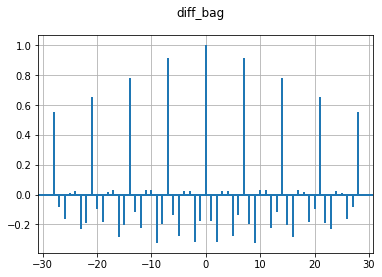

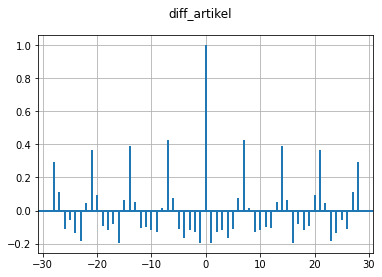

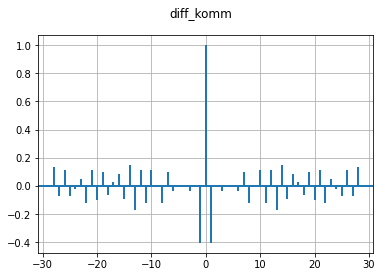

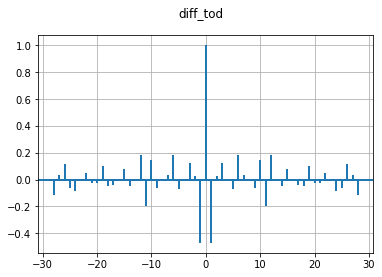

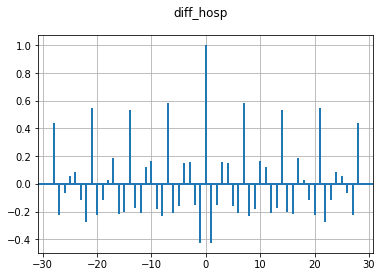

In [23]:
acf_maker(x_diff)

## Partial Autocorrelation

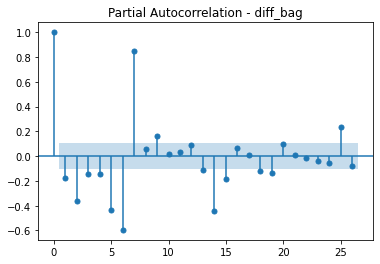

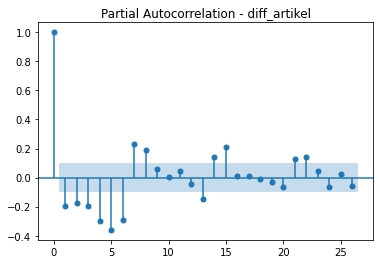

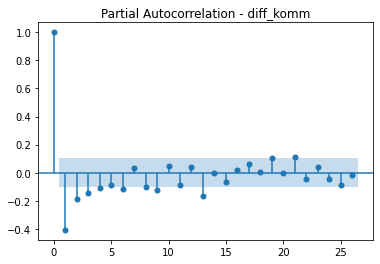

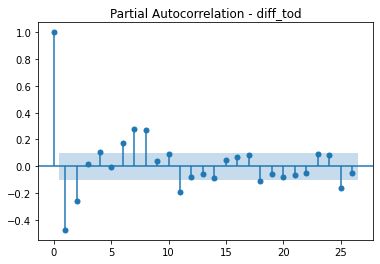

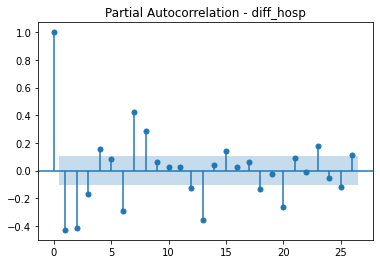

In [24]:
pacf_maker(x_diff)

## Cross Correlation

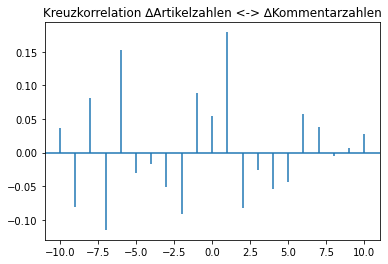

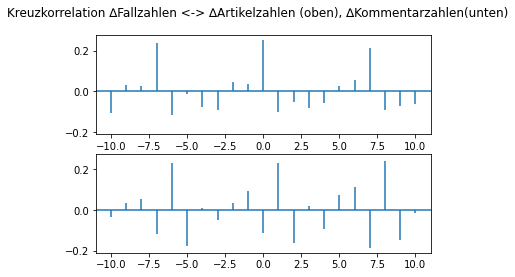

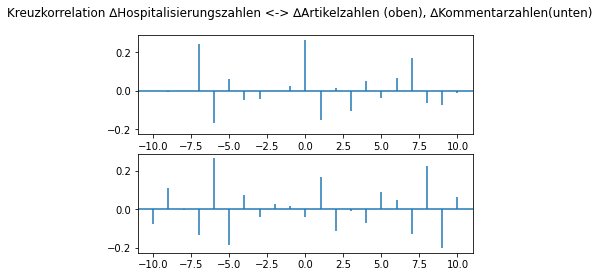

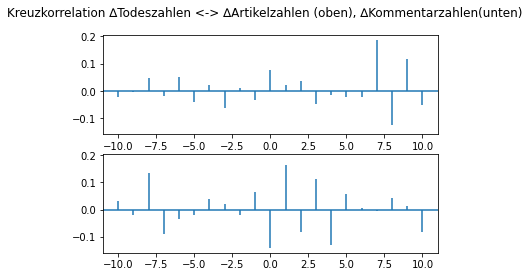

In [25]:
cor_shower(x)

## Granger Causality

#### Getting the number of lags

Serial Correlation of Residuals using Durbin Watson Statistic
diff_artikel : 2.03
diff_komm : 2.04
diff_bag : 2.0
diff_tod : 2.15
diff_hosp : 2.1


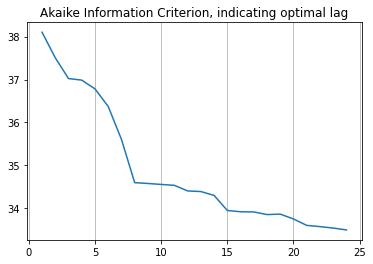

In [26]:
lagger(x)

fitter(x_diff, 7)   #basing on the plot and the elbow from lagger(x_diff), we take 7 (in the example). 
                    #In case the plot shows something different to you, use this number

#### Actual Granger Causality

In [27]:
maxlag = 8
o = grangers_causation_matrix(x_diff, variables = x_diff.columns)  
o

,diff_artikel_x,diff_komm_x,diff_bag_x,diff_tod_x,diff_hosp_x
diff_artikel_y,1.0000,0.0000,0.0042,0.6964,0.0012
diff_komm_y,0.0013,1.0000,0.0000,0.0111,0.0002
diff_bag_y,0.0273,0.0000,1.0000,0.0029,0.0000
diff_tod_y,0.0010,0.0056,0.0000,1.0000,0.0000
diff_hosp_y,0.0000,0.0002,0.0000,0.0003,1.0000
